In [ ]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.7 MB/s eta 0:00:00


In [ ]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from brian2 import prefs
prefs.codegen.target = 'cython'

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]
y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4
X_test = X_test / 4

X_train.shape, X_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((18516, 28, 28), (3089, 28, 28))

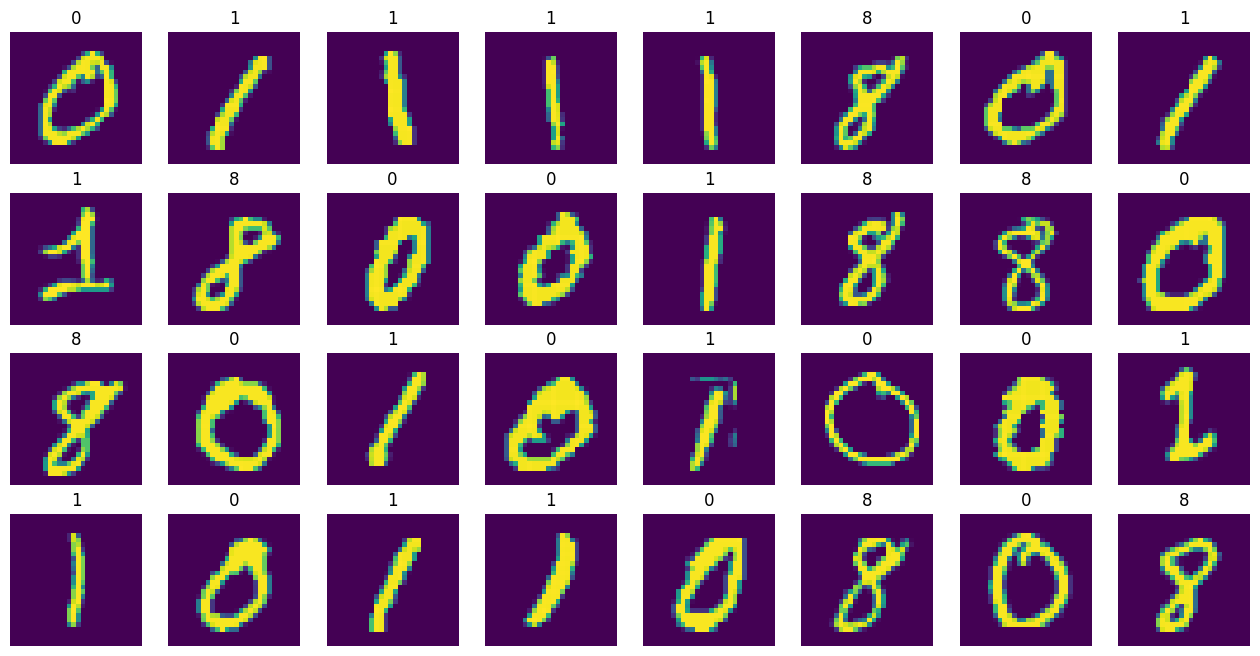

In [ ]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [ ]:
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():

    def __init__(self, debug=False):
        app = {}

        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M')

        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        self.net['S1'].lr = 1 # stdp on

        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)

    def evaluate(self, X):
        self.net['S1'].lr = 0  # stdp off

        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)

            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))

            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)

            self.net.remove(self.net['RM'])

        return features

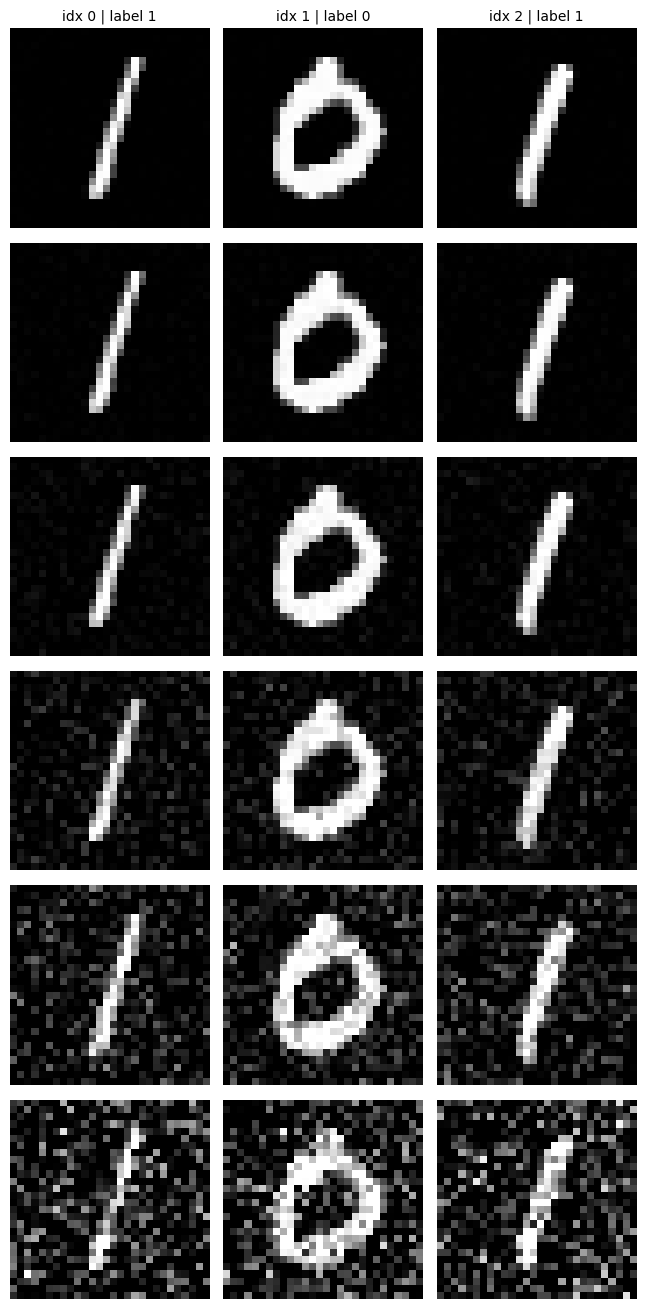

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_noisy_grid_with_labels(X, y, snr_values, k=3, max_val=63.75):
    """
    X           — array of images (e.g., X_test), shape: (N, 28*28) or (N, 28, 28)
    y           — labels (e.g., y_test), shape: (N,)
    snr_values  — list of SNR levels in dB, e.g., [40, 30, 20, 10, 5, 0]
    k           — how many first images to display per SNR
    max_val     — maximum intensity value (for your scaling ~63.75)
    """
    # Ensure X has shape (N, 28, 28)
    Ximg = X.reshape(len(X), 28, 28) if X.ndim == 2 else X

    rows, cols = len(snr_values), k
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.2, rows*2.2))

    # Normalize axes array shape to always be 2D
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    for row, snr_db in enumerate(snr_values):
        # Generate noisy version of the full dataset (or slice up to k for speed)
        X_noisy = add_gaussian_noise_snr(Ximg, snr_db)
        X_noisy = np.clip(X_noisy, 0, max_val)

        for col in range(cols):
            ax = axes[row, col]
            ax.imshow(X_noisy[col], cmap='gray', vmin=0, vmax=max_val)
            ax.axis('off')

            # Add SNR label on the left (Y-axis)
            if col == 0:
                ax.set_ylabel(f"SNR={snr_db} dB", fontsize=10)

            # Add titles on the top row with index and true label
            if row == 0:
                ax.set_title(f"idx {col} | label {y[col]}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Example run
snr_values = [40, 30, 20, 10, 5, 0]
show_noisy_grid_with_labels(X_test, y_test, snr_values, k=3, max_val=63.75)

In [ ]:
def _clip_to_data_range(X_tr, X_te, clip_max=None):
    """
    Clip values to [0, cap], where cap is either provided explicitly,
    or taken as the maximum from the original X_train/X_test.
    """
    if clip_max is None:
        # Take the maximum from the real data (accounts for your /4 → ~63.75)
        cap = float(max(np.max(X_train), np.max(X_test)))
    else:
        cap = float(clip_max)
    return np.clip(X_tr, 0, cap), np.clip(X_te, 0, cap), cap


def test2(assign_items=1000, eval_items=500, snr_db=None, clip_max=None):
    """
    Freeze STDP at the start (do not train the SNN)
    Steps:
    1) Pass train data through SNN → f_train
    2) Train RandomForest on f_train, y_train
    3) Pass test data through SNN → f_test
    4) Compute accuracy and confusion matrix
    """
    seed(0)

    Xtr = X_train.copy()
    Xte = X_test.copy()

    # Add Gaussian noise if snr_db is specified
    if snr_db is not None:
        Xtr = add_gaussian_noise_snr(Xtr, snr_db)
        Xte = add_gaussian_noise_snr(Xte, snr_db)
        # Clip data to [0, cap]
        Xtr, Xte, cap = _clip_to_data_range(Xtr, Xte, clip_max=clip_max)

    model = Model()  # STDP is frozen: no model.train(...)
    f_train = model.evaluate(Xtr[:assign_items])

    # Train RandomForest classifier
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])

    # Evaluate test set
    f_test = model.evaluate(Xte[:eval_items])
    y_pred = clf.predict(f_test)

    # Compute accuracy and confusion matrix
    acc = accuracy_score(y_pred, y_test[:eval_items])
    cm = confusion_matrix(y_pred, y_test[:eval_items])
    return acc, cm


In [ ]:
def test3(train_items=1000, eval_items=500, snr_db=None, clip_max=None):
    """
    Бейзлайн: RandomForest без SNN
    """
    seed(0)

    Xtr = X_train.copy()
    Xte = X_test.copy()

    if snr_db is not None:
        Xtr = add_gaussian_noise_snr(Xtr, snr_db)
        Xte = add_gaussian_noise_snr(Xte, snr_db)
        Xtr, Xte, cap = _clip_to_data_range(Xtr, Xte, clip_max=clip_max)

    clf = RandomForestClassifier(max_depth=4, random_state=0)

    train_features = Xtr[:train_items].reshape(-1, 28*28)
    clf.fit(train_features, y_train[:train_items])
    # train_acc = clf.score(train_features, y_train[:train_items])  # при желании

    test_features = Xte[:eval_items].reshape(-1, 28*28)
    y_pred = clf.predict(test_features)

    acc = accuracy_score(y_pred, y_test[:eval_items])
    cm = confusion_matrix(y_pred, y_test[:eval_items])
    return acc, cm

SNR=40 dB → test2(acc)=0.846, test3(acc)=0.980
SNR=30 dB → test2(acc)=0.848, test3(acc)=0.984
SNR=20 dB → test2(acc)=0.828, test3(acc)=0.982
SNR=10 dB → test2(acc)=0.804, test3(acc)=0.976
SNR=5 dB → test2(acc)=0.682, test3(acc)=0.976
SNR=0 dB → test2(acc)=0.658, test3(acc)=0.942


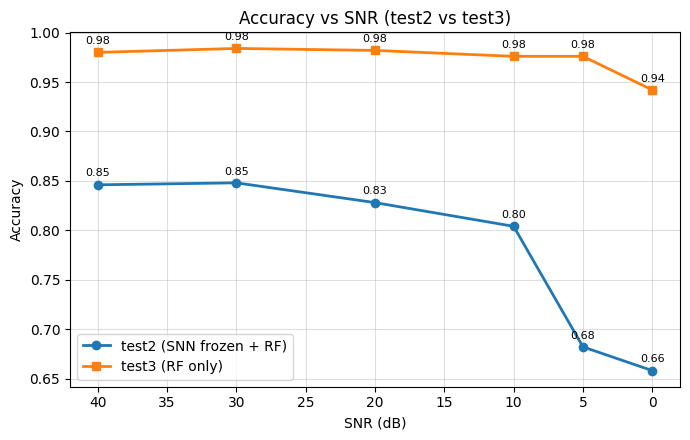

In [ ]:
snr_values = [40, 30, 20, 10, 5, 0]
acc2, acc3 = [], []

# Collect accuracies
for snr in snr_values:
    a2, _ = test2(assign_items=1000, eval_items=500, snr_db=snr)   # or clip_max=63.75 if needed
    a3, _ = test3(train_items=1000, eval_items=500, snr_db=snr)   # or clip_max=63.75 if needed
    print(f"SNR={snr} dB → test2(acc)={a2:.3f}, test3(acc)={a3:.3f}")
    acc2.append(a2)
    acc3.append(a3)

# Plot
plt.figure(figsize=(7, 4.5))
plt.plot(snr_values, acc2, marker='o', linewidth=2, label='test2 (SNN frozen + RF)')
plt.plot(snr_values, acc3, marker='s', linewidth=2, label='test3 (RF only)')
plt.gca().invert_xaxis()  # higher SNR on the left, lower on the right
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR (test2 vs test3)')
plt.grid(True, alpha=0.4)
plt.legend(loc='best')

# Optional: annotate points with exact values
for x, y in zip(snr_values, acc2):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 6), ha='center', fontsize=8)
for x, y in zip(snr_values, acc3):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 6), ha='center', fontsize=8)

plt.tight_layout()
plt.show()